# ОИАД. Лабораторная работа №4

Используйте набор данных **datasets/famcs_students.csv**

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную $y=$ binary_cols[N % 8], где $N$ - номер в списке группы. Остальные переменные используйте в качестве признаков $X$ (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации $y$ по признакам $X$.

Разделите случайно исходные данные на 3 выборки:
* тренировочная (70%) - для определения параметров модели
* валидацонная (15%) - для подбора гиперпараметров модели
* тестовую (15%) - итоговая оценка качества



In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import math

In [63]:
df = pd.read_csv('../datasets/famcs_students.csv')

N = 21
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
y_col = binary_cols[N%8]
print(f"Целевая переменная: {y_col}")
df.info()

Целевая переменная: anime
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cource           127 non-null    int64  
 1   group            127 non-null    int64  
 2   stream           127 non-null    object 
 3   sex              127 non-null    object 
 4   age              127 non-null    float64
 5   ss               127 non-null    object 
 6   interest         127 non-null    object 
 7   os               127 non-null    object 
 8   weekend_study    127 non-null    object 
 9   bad_sleep        127 non-null    object 
 10  glasses          127 non-null    object 
 11  work_experience  127 non-null    object 
 12  ai               127 non-null    object 
 13  height           127 non-null    float64
 14  anime            127 non-null    object 
 15  social           127 non-null    object 
 16  sport            127 non-null    obj

In [64]:
cols = list(df.columns)
cols.remove(y_col)
X = df[cols]
y = df[y_col]
print(f"Используемые признаки: {X.columns.tolist()}")

Используемые признаки: ['cource', 'group', 'stream', 'sex', 'age', 'ss', 'interest', 'os', 'weekend_study', 'bad_sleep', 'glasses', 'work_experience', 'ai', 'height', 'social', 'sport', 'miss', 'study_form', 'foot_size', 'eye_color', 'score', 'retake', 'hostel', 'literature']


In [65]:
label_encoders = {}
X_encoded = X.copy()

for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le


le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)


X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 88, Val: 19, Test: 20


## 0. Тривиальный классификатор
Всегда выдает наиболее частый класс



In [66]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def evaluate_model(name, y_true, y_pred):
    acc = accuracy(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{name}:")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-score: {f1:.3f}")
    print("Confusion Matrix:")
    print(f"[[{cm[0,0]:2d} {cm[0,1]:2d}]")
    print(f" [{cm[1,0]:2d} {cm[1,1]:2d}]]")
    
    return acc, prec, rec, f1

In [73]:
class TrivialClassifier:
    def fit(self, y):
        self.most_common = Counter(y).most_common(1)[0][0]
    
    def predict(self, X):
        return np.array([self.most_common] * len(X))

trivial = TrivialClassifier()
trivial.fit(y_train)
y_pred_trivial = trivial.predict(X_test)

evaluate_model("Trivial Classifier", y_test, y_pred_trivial)
print('')


Trivial Classifier:
Accuracy: 0.550
Precision: 0.550
Recall: 1.000
F1-score: 0.710
Confusion Matrix:
[[ 0  9]
 [ 0 11]]



## 1. Наивный байесовский классификатор
Алгоритм реализуйте сами!



In [68]:
X_train_nb = X_train.copy()
X_val_nb = X_val.copy()
X_test_nb = X_test.copy()


In [75]:
class NaiveBayesClassifier:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                'prior': len(X_c) / len(X),
                'mean': X_c.mean(axis=0),
                'std': X_c.std(axis=0) + 1e-6
            }
    
    def _calculate_probability(self, x, mean, std):
        exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent
    
    def predict_proba(self, X):
        results = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.parameters[c]['prior'])
                likelihood = np.sum(np.log(self._calculate_probability(x, 
                    self.parameters[c]['mean'], 
                    self.parameters[c]['std'])))
                posterior = prior + likelihood
                posteriors.append(posterior)
            
            posteriors = np.array(posteriors)
            max_posterior = np.max(posteriors)
            exp_posteriors = np.exp(posteriors - max_posterior)
            probabilities = exp_posteriors / np.sum(exp_posteriors)
            results.append(probabilities)
        
        return np.array(results)
    
    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        return (probas[:, 1] > threshold).astype(int)


In [77]:
nb = NaiveBayesClassifier()
nb.fit(X_train.values, y_train)
y_pred_nb = nb.predict(X_test.values)
evaluate_model("Naive Bayes", y_test, y_pred_nb)
print('')


Naive Bayes:
Accuracy: 0.650
Precision: 0.700
Recall: 0.636
F1-score: 0.667
Confusion Matrix:
[[ 6  3]
 [ 4  7]]



## 2. Метод k-ближайших соседей
Алгоритм реализуйте сами!
Подберите оптимальный гиперпараметр $k$.



In [79]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict(self, X):
        predictions = []
        for x in X:
            distances = []
            for i, x_train in enumerate(self.X_train):
                dist = self._euclidean_distance(x, x_train)
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            k_nearest_labels = [label for _, label in k_nearest]
            
            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)
        
        return np.array(predictions)

print("ПОДБОР ГИПЕРПАРАМЕТРА K ДЛЯ KNN")
k_values = [2, 3, 5, 7, 9, 11]
best_k = 3
best_f1 = 0

for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(X_train.values, y_train)
    y_pred_knn_val = knn.predict(X_val.values)
    f1 = f1_score(y_val, y_pred_knn_val)
    
    print(f"k={k}: F1-score = {f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"\nЛучшее k: {best_k}")

ПОДБОР ГИПЕРПАРАМЕТРА K ДЛЯ KNN
k=2: F1-score = 0.560
k=3: F1-score = 0.714
k=5: F1-score = 0.692
k=7: F1-score = 0.640
k=9: F1-score = 0.640
k=11: F1-score = 0.583

Лучшее k: 3


In [81]:
knn = KNNClassifier(k=best_k)
knn.fit(X_train.values, y_train)
y_pred_knn = knn.predict(X_test.values)
evaluate_model(f"KNN (k={best_k})", y_test, y_pred_knn)
print('')


KNN (k=3):
Accuracy: 0.550
Precision: 0.571
Recall: 0.727
F1-score: 0.640
Confusion Matrix:
[[ 3  6]
 [ 3  8]]



## 3. Логистическая регрессия
Алгоритм реализуйте сами!
Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.



In [82]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250))) 
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        return (probas >= threshold).astype(int)


lr = LogisticRegression(learning_rate=0.1, n_iter=1000)
lr.fit(X_train.values, y_train)



Подбор оптимального порога классификации...
Лучший порог: 0.000


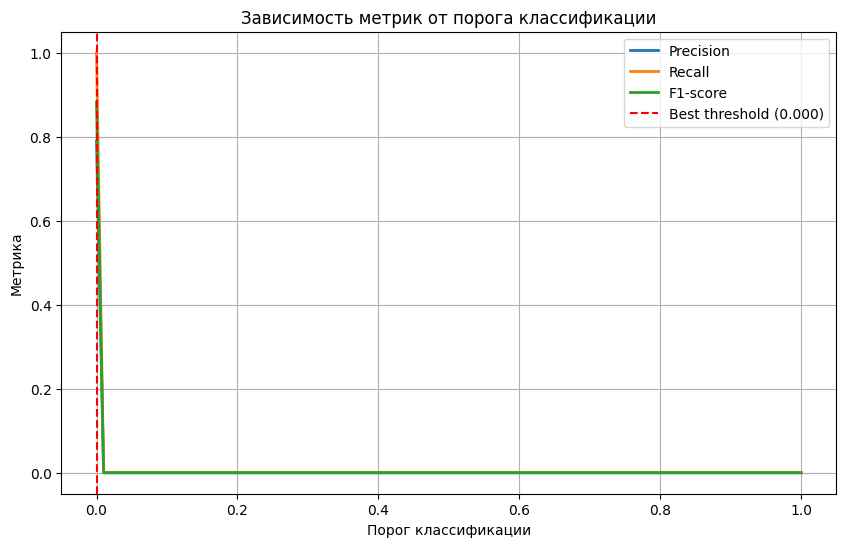


Логистическая регрессия на тестовой выборке:

Logistic Regression (threshold=0.000):
Accuracy: 0.550
Precision: 0.550
Recall: 1.000
F1-score: 0.710
Confusion Matrix:
[[ 0  9]
 [ 0 11]]



In [90]:
print("Подбор оптимального порога классификации...")
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

y_pred_val_proba = lr.predict_proba(X_val.values)

for threshold in thresholds:
    y_pred_val = (y_pred_val_proba >= threshold).astype(int)
    precisions.append(precision(y_val, y_pred_val))
    recalls.append(recall(y_val, y_pred_val))
    f1_scores.append(f1_score(y_val, y_pred_val))

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Лучший порог: {best_threshold:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold ({best_threshold:.3f})')
plt.xlabel('Порог классификации')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от порога классификации')
plt.legend()
plt.grid(True)
plt.show()

print("\nЛогистическая регрессия на тестовой выборке:")
y_pred_lr = lr.predict(X_test.values, threshold=best_threshold)
evaluate_model(f"Logistic Regression (threshold={best_threshold:.3f})", y_test, y_pred_lr)
print('')